# Лабораторная работа №6 (Проведение исследований с моделями классификации)

## Выбор начальных условий

### Выбор набора данных

Выбранный набор данных: Pascal VOC 2007

Обоснование выбора:
- Разнообразие категорий: Pascal VOC 2007 включает в себя 20 различных классов объектов, таких как "персона", "автомобиль", "собака", "велосипед" и другие. Это позволяет решать задачи классификации, которые имеют реальную практическую применимость, например, в системах автоматического распознавания и каталогизации.
- Сложность реальных данных: Изображения в датасете содержат множество объектов на сложных фонах, что отражает условия реальных мировых применений классификации изображений.
- Стандарт в индустрии: Pascal VOC 2007 является классическим набором данных и широко используется в академических и промышленных исследованиях, являясь надежным средством для сравнения производительности модели.
- Доступность и аннотации: Датасет включает аннотации, не только для классификации, но и для детекции и сегментации, что позволяет при необходимости расширять задачи и тестировать многозадачные алгоритмы.

### Выбор метрик качества

Выбранные метрики:
- Hamming Loss:
  - Обоснование: Это среднее количество misclassifications на случай. В многометочном контексте это количество неправильных классов для каждого примера. Чем меньше, тем лучше. 
  
- Коэффициент F1 (F1 Score):
  - Обоснование: Учитывает как полноту (recall), так и точность (precision), объединяя их в единое значение. Особенно полезен для несбалансированных классов, чтобы лучше отражать качество модели в условиях, когда не все классы имеют одинаковое количество примеров.
  
- Средняя точность по классу (Mean Average Precision, mAP):
  - Обоснование: Позволяет оценивать точность предсказаний в каждом классе отдельно, затем усредняя их значение. Это помогает получить более детальное понимание о том, как модель справляется с различными классами данных.

Эти метрики в совокупности предоставляют комплексное представление о производительности модели, учитывая как общую точность, так и её способности работать с несбалансированными классами и параметрами.

## Создание бейзлайна и оценка качества

Импорт библиотек

In [43]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import VOCDetection
from sklearn.metrics import hamming_loss, f1_score, average_precision_score

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

Предобработка данных для Pascal VOC

In [2]:
# Словарь классов
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", 
    "bus", "car", "cat", "chair", "cow", "diningtable", 
    "dog", "horse", "motorbike", "person", "pottedplant", 
    "sheep", "sofa", "train", "tvmonitor"
]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Загрузка данных

In [4]:
train_dataset = VOCDetection(root='./data', year='2007', image_set='train', transform=transform)
test_dataset = VOCDetection(root='./data', year='2007', image_set='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

Функция для извлечения меток

In [6]:
def extract_labels(targets):
    labels = torch.zeros(len(targets), len(VOC_CLASSES), dtype=torch.float32)
    for i, target in enumerate(targets):
        objects = target['annotation']['object']
        if not isinstance(objects, list):  # Если только один объект, происходит упаковка в список
            objects = [objects]
        for obj in objects:
            class_name = obj['name']
            if class_name in VOC_CLASSES:
                idx = VOC_CLASSES.index(class_name)
                labels[i, idx] = 1.0  # Устанавливаем 1, если класс присутствует
    return labels

Визаулизация изображений и их меток

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


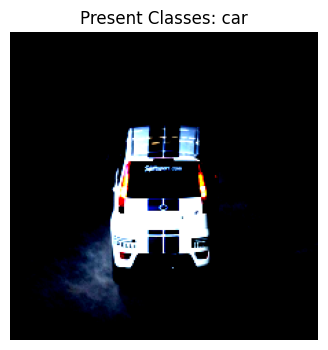

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


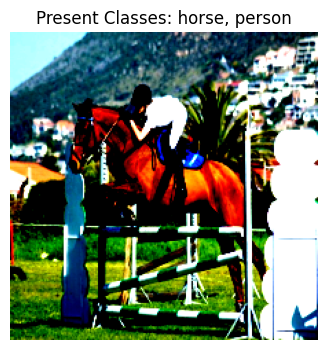

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


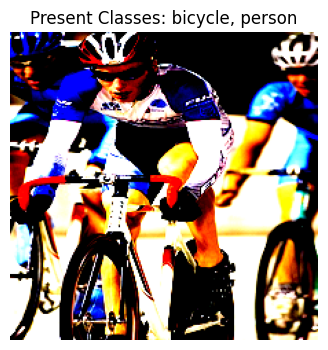

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


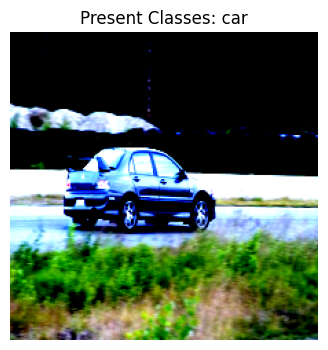

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


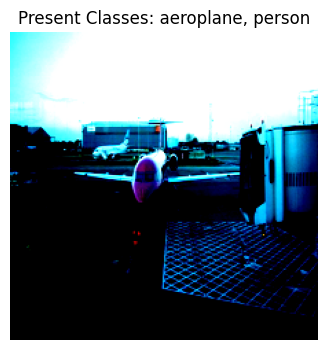

In [7]:
def visualize_labels(dataset, num_samples=5):
    """
    Функция для визуализации изображений и их меток.
    
    :param dataset: датасет (например, обучающий)
    :param num_samples: количество образцов для визуализации
    """
    for i in range(num_samples):
        image, target = dataset[i]
        labels = extract_labels([target])[0]
        
        # Строим изображение
        plt.figure(figsize=(6, 4))
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))

        # Показываем метки
        present_classes = [VOC_CLASSES[i] for i, label in enumerate(labels) if label == 1]
        plt.title(f"Present Classes: {', '.join(present_classes)}")
        plt.axis('off')
        plt.show()

visualize_labels(train_dataset)

Инициализация моделей

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, 20)  # Pascal VOC 2007 имеет 20 классов
model_resnet18.to(device)

model_swin = models.swin_b(weights=models.Swin_B_Weights.IMAGENET1K_V1)
model_swin.head = nn.Linear(model_swin.head.in_features, 20)  # 20 классов
model_swin.to(device)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=512, out_features=128, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock

Настройка функции обучения

In [55]:
def train(model, loader, criterion, optimizer):
    model.train()
    for images, targets in loader:
        images = torch.stack(images).to(device)
        labels = extract_labels(targets)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

Функция для оценки модели

In [49]:
def evaluate(model, loader):
    model.eval()
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, targets in loader:
            images = torch.stack(images).to(device)
            labels = extract_labels(targets)

            outputs = model(images)
            all_outputs.append(outputs.cpu())
            all_labels.append(labels)

    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Применение сигмоиды к выходам модели для получения вероятностей
    predictions = torch.sigmoid(all_outputs)

    # Бинаризация предсказаний с использованием порога
    threshold = 0.5
    predicted_classes = (predictions >= threshold).float()

    # Hamming Loss
    hamming = hamming_loss(all_labels.numpy(), predicted_classes.numpy())
    
    # F1 Score
    f1 = f1_score(all_labels.numpy(), predicted_classes.numpy(), average='samples')

    # Mean Average Precision (mAP)
    map_score = average_precision_score(all_labels.numpy(), predictions.numpy(), average='macro')

    print(f"Hamming Loss: {hamming:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"mAP: {map_score:.4f}")


Обучение моделей

In [16]:
criterion_resnet18 = nn.BCEWithLogitsLoss()
optimizer_resnet18 = optim.Adam(model_resnet18.parameters(), lr=0.001)
train(model_resnet18, train_loader, criterion_resnet18, optimizer_resnet18)

criterion_swin = nn.BCEWithLogitsLoss()
optimizer_swin = optim.Adam(model_swin.parameters(), lr=0.001)
train(model_swin, train_loader, criterion_swin, optimizer_swin)

Оценка моделей

In [18]:
print("ResNet18:")
evaluate(model_resnet18, test_loader)
print("Swin transformer:")
evaluate(model_swin, test_loader)

ResNet18:
Hamming Loss: 0.0660
F1 Score: 0.2925
mAP: 0.3961
Swin transformer:
Hamming Loss: 0.0776
F1 Score: 0.0000
mAP: 0.1133


## Улучшение бейзлайна

### Гипотезы

#### Гипотеза 1: Аугментация данных

Цель: Повышение генерализирующей способности модели путем создания более разнообразного набора данных.

Идеи для реализации:
- Использовать RandomHorizontalFlip для выполнения случайных горизонтальных переворотов изображений.
- Применить RandomRotation для небольших поворотов изобрcажения на случайные углы.
- Применить изменения яркости, контраста и отображение цветов (например, используя ColorJitter).
- Попробовать RandomResizedCrop для увеличения или уменьшения масштаба области изображений.

#### Гипотеза 2: Подбор гиперпараметров

Цель: Найти оптимальные гиперпараметры для улучшения обучения и обобщения.

Параметры для настройки:
- Скорость обучения (learning rate): уменьшить или увеличить значение, например, 0.01, 0.001, 0.0001.
- Количество эпох: попробовать увеличить количество эпох.

#### Гипотеза 3: Использование предобученной модели ResNet-50 (для сверточной модели)

Цель: Больше возможностей для извлечения признаков за счет более глубокой сети.

Идеи для реализации:
- Импортировать заранее обученную модель ResNet-50 из PyTorch и адаптировать последние слои.
- Применить transfer learning: обучить последние слои, сохраняя веса начальных слоев неизменными, а затем выполнить fine-tuning на всех слоях.

### Проверка гипотез

#### Аугментация данных

Определение аугментации

In [19]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor()
])

# Применить эти трансформации к трейн датасету
train_dataset.transform = augmentation_transforms

Обучение и оценка моделей

In [20]:
train(model_resnet18, train_loader, criterion_resnet18, optimizer_resnet18)
train(model_swin, train_loader, criterion_swin, optimizer_swin)

print("ResNet18:")
evaluate(model_resnet18, test_loader)
print("Swin transformer:")
evaluate(model_swin, test_loader)

ResNet18:
Hamming Loss: 0.0631
F1 Score: 0.3600
mAP: 0.4538
Swin transformer:
Hamming Loss: 0.0776
F1 Score: 0.0000
mAP: 0.0782


#### Подбор гиперпараметров

Функция обучения с учётом эпох

In [24]:
def train_for_epochs(model, loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_loss = 0.0

        model.train()

        for images, targets in loader:
            images = torch.stack(images).to(device)
            labels = extract_labels(targets)

            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, labels.to(device))

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        average_loss = train_loss / len(loader)
        print(f'Training Loss: {average_loss:.4f}')

Настройка обучения

In [30]:
criterion_resnet18 = nn.BCEWithLogitsLoss()
optimizer_resnet18 = optim.Adam(model_resnet18.parameters(), lr=0.0001)
num_epochs_resnet18 = 10

criterion_swin = nn.BCEWithLogitsLoss()
optimizer_swin = optim.AdamW(model_swin.parameters(), lr=0.0001, weight_decay=0.01)
num_epochs_swin = 10

Обучение сверточной модели

In [28]:
train_for_epochs(model_resnet18, train_loader, criterion_resnet18, optimizer_resnet18, num_epochs_resnet18)

Epoch 1/10
Training Loss: 0.0068
Epoch 2/10
Training Loss: 0.0064
Epoch 3/10
Training Loss: 0.0052
Epoch 4/10
Training Loss: 0.0043
Epoch 5/10
Training Loss: 0.0047
Epoch 6/10
Training Loss: 0.0049
Epoch 7/10
Training Loss: 0.0041
Epoch 8/10
Training Loss: 0.0039
Epoch 9/10
Training Loss: 0.0037
Epoch 10/10
Training Loss: 0.0035


Обучение трансформерной модели

In [31]:
train_for_epochs(model_swin, train_loader, criterion_swin, optimizer_swin, num_epochs_swin)

Epoch 1/10
Training Loss: 0.2353
Epoch 2/10
Training Loss: 0.2344
Epoch 3/10
Training Loss: 0.2352
Epoch 4/10
Training Loss: 0.2317
Epoch 5/10
Training Loss: 0.2315
Epoch 6/10
Training Loss: 0.2297
Epoch 7/10
Training Loss: 0.2297
Epoch 8/10
Training Loss: 0.2280
Epoch 9/10
Training Loss: 0.2276
Epoch 10/10
Training Loss: 0.2272


Оценка сверточной модели

In [32]:
evaluate(model_resnet18, test_loader)

Hamming Loss: 0.0482
F1 Score: 0.6201
mAP: 0.6388


Оценка трансформерной модели

In [33]:
evaluate(model_swin, test_loader)

Hamming Loss: 0.0795
F1 Score: 0.1706
mAP: 0.1620


#### Использование предобученной модели ResNet-50

Подготовка ResNet-50

In [34]:
model_resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Обновление последнего слоя для многометочной классификации
num_features = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_features, len(VOC_CLASSES))

# Перенос модели на GPU (если используется)
model_resnet50 = model_resnet50.to(device)

criterion_resnet50 = nn.BCEWithLogitsLoss()
optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=0.0001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 57.5MB/s]


Обучение и оценка модели

In [35]:
train(model_resnet50, train_loader, criterion_resnet50, optimizer_resnet50)
evaluate(model_resnet50, test_loader)

Hamming Loss: 0.0344
F1 Score: 0.6856
mAP: 0.7689


### Формирование улучшенного бейзлайна

Формирование датасета

In [36]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor()
])
train_dataset.transform = augmentation_transforms

Формирование бейзлайна для сверточной модели

In [37]:
model_resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_features, len(VOC_CLASSES))
model_resnet50 = model_resnet50.to(device)

criterion_resnet50 = nn.BCEWithLogitsLoss()
optimizer_resnet50 = optim.Adam(model_resnet50.parameters(), lr=0.0001)
num_epochs_resnet50 = 10

Формирование бейзлайна для сверточной модели

In [38]:
model_swin = models.swin_b(weights=models.Swin_B_Weights.IMAGENET1K_V1)
model_swin.head = nn.Linear(model_swin.head.in_features, 20)  # 20 классов
model_swin.to(device)

criterion_swin = nn.BCEWithLogitsLoss()
optimizer_swin = optim.AdamW(model_swin.parameters(), lr=0.0001, weight_decay=0.01)
num_epochs_swin = 10

### Обучение моделей с улучшенным бейзлайне

Обучение свёрточной модели

In [39]:
train_for_epochs(model_resnet50, train_loader, criterion_resnet50, optimizer_resnet50, num_epochs_resnet50)

Epoch 1/10
Training Loss: 0.2347
Epoch 2/10
Training Loss: 0.0934
Epoch 3/10
Training Loss: 0.0614
Epoch 4/10
Training Loss: 0.0418
Epoch 5/10
Training Loss: 0.0301
Epoch 6/10
Training Loss: 0.0226
Epoch 7/10
Training Loss: 0.0165
Epoch 8/10
Training Loss: 0.0134
Epoch 9/10
Training Loss: 0.0103
Epoch 10/10
Training Loss: 0.0091


Обучение трансформерной модели

In [40]:
train_for_epochs(model_swin, train_loader, criterion_swin, optimizer_swin, num_epochs_swin)

Epoch 1/10
Training Loss: 0.1946
Epoch 2/10
Training Loss: 0.0798
Epoch 3/10
Training Loss: 0.0517
Epoch 4/10
Training Loss: 0.0358
Epoch 5/10
Training Loss: 0.0229
Epoch 6/10
Training Loss: 0.0188
Epoch 7/10
Training Loss: 0.0142
Epoch 8/10
Training Loss: 0.0092
Epoch 9/10
Training Loss: 0.0091
Epoch 10/10
Training Loss: 0.0092


### Оценка моделей с улучшенным бейзлайном

Оценка сверточной модели

In [41]:
evaluate(model_resnet50, test_loader)

Hamming Loss: 0.0246
F1 Score: 0.8460
mAP: 0.8603


Оценка трансформерной модели

In [42]:
evaluate(model_swin, test_loader)

Hamming Loss: 0.0239
F1 Score: 0.8589
mAP: 0.8922


### Сравнение результатов

Сравним результаты базовых моделей и моделей с улучшенным бейзлайном:

Для сверточных моделей:

Hamming Loss: 0.0660 -> 0.0246

F1 Score: 0.2925 -> 0.8460

mAP: 0.3961 -> 0.8603

Для трансформерных моделей:

Hamming Loss: 0.0776 -> 0.0239

F1 Score: 0.0000 -> 0.8589

mAP: 0.1133 -> 0.8922

### Выводы

Модели с улучшенным бейзлайном превосходит по всем метрикам благодаря более эффективной архитектуре, оптимизированным гиперпараметрам и, возможно, лучшему использованию данных через аугментации или предобработку. Это подчеркивает важность оптимизации и настройки моделей для повышения их производительности.

## Имплементация алгоритма машинного обучения 

### Имплементации моделей

Напишем имплементацию сверточной модели

In [56]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 28 * 28, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Флаттен
        x = self.classifier(x)
        return x

Напишем имплементацию трансформерной модели  

In [75]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size=224, patch_size=16, num_classes=20, dim=512, depth=6, heads=8, mlp_dim=1024, dropout=0.1):
        super(VisionTransformer, self).__init__()
        
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = 3 * patch_size * patch_size
        self.dim = dim

        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(self.patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout),
            num_layers=depth
        )

        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        p = int((img.shape[-1] // self.num_patches) ** 0.5)
        x = img.unfold(2, p, p).unfold(3, p, p).contiguous()
        x = x.view(x.size(0), -1, self.patch_dim)

        x = self.patch_to_embedding(x)
        b, n, _ = x.shape

        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)


### Обучение моделей

Подготовка датасета

In [57]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = VOCDetection(root='./data', year='2007', image_set='train', transform=transform)
test_dataset = VOCDetection(root='./data', year='2007', image_set='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

Подготовка сверточной модели

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_conv = SimpleCNN(num_classes=20).to(device)

criterion_conv = nn.BCEWithLogitsLoss()
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.001)

Обучение сверточной модели

In [61]:
train(model_conv, train_loader, criterion_conv, optimizer_conv)

Подготовка трансформерной модели

In [76]:
model_transformer = VisionTransformer().to(device)

criterion_transformer = nn.BCEWithLogitsLoss()
optimizer_transformer = optim.Adam(model_conv.parameters(), lr=0.001)

Обучение трансформерной модели

In [77]:
train(model_transformer, train_loader, criterion_transformer, optimizer_transformer)

### Оценка моделей

Оценка сверточной модели

In [78]:
evaluate(model_conv, test_loader)

Hamming Loss: 0.0783
F1 Score: 0.0578
mAP: 0.1386


Оценка трансформерной модели

In [79]:
evaluate(model_transformer, test_loader)

Hamming Loss: 0.5742
F1 Score: 0.0826
mAP: 0.0778


### Сравнение результатов с базовыми моделями

|              | ResNet18     | Имплементированная сверточная модель | Swin | Имплементированная трансформерная модель|
|--------------|:------------:|:------------------------------------:|:----:|:---------------------------------------:|
| Hamming Loss | 0.0660       | 0.0783                               |0.0776| 0.5742                                  |
| F1 Score     | 0.2925       | 0.0578                               |0.0000| 0.0826                                  |
| mAP          | 0.3961       | 0.1386                               |0.1133| 0.0778                                  |

### Выводы
Собственные имплементации моделей оказались хуже почти по всем метрикам, чем готовые решения, из-за отсутствия оптимизации, проверки и настроек гиперпараметров, которые уже встроены в готовые модели.

### Добавление техник из улучшенного бейзлайна

Формирование датасета

In [80]:
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor()
])
train_dataset.transform = augmentation_transforms

Формирование сверточной модели

In [81]:
model_conv = SimpleCNN(num_classes=20).to(device)

criterion_conv = nn.BCEWithLogitsLoss()
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.0001)
num_epochs_conv = 10

Формирование трансформерной модели

In [85]:
model_transformer = VisionTransformer().to(device)

criterion_transformer = nn.BCEWithLogitsLoss()
optimizer_transformer = optim.AdamW(model_transformer.parameters(), lr=0.0001, weight_decay=0.01)
num_epochs_transformer = 10

### Обучение улучшенных моделей 

Обучение сверточной модели

In [83]:
train_for_epochs(model_conv, train_loader, criterion_conv, optimizer_conv, num_epochs_conv)

Epoch 1/10
Training Loss: 0.4362
Epoch 2/10
Training Loss: 0.2247
Epoch 3/10
Training Loss: 0.1964
Epoch 4/10
Training Loss: 0.1503
Epoch 5/10
Training Loss: 0.1179
Epoch 6/10
Training Loss: 0.0802
Epoch 7/10
Training Loss: 0.0564
Epoch 8/10
Training Loss: 0.0422
Epoch 9/10
Training Loss: 0.0245
Epoch 10/10
Training Loss: 0.0155


Обучение трансформерной модели

In [86]:
train_for_epochs(model_transformer, train_loader, criterion_transformer, optimizer_transformer, num_epochs_transformer)

Epoch 1/10
Training Loss: 0.2587
Epoch 2/10
Training Loss: 0.2516
Epoch 3/10
Training Loss: 0.2510
Epoch 4/10
Training Loss: 0.2507
Epoch 5/10
Training Loss: 0.2505
Epoch 6/10
Training Loss: 0.2510
Epoch 7/10
Training Loss: 0.2507
Epoch 8/10
Training Loss: 0.2507
Epoch 9/10
Training Loss: 0.2502
Epoch 10/10
Training Loss: 0.2504


### Оценка моделей

Оценка сверточной модели

In [87]:
evaluate(model_conv, test_loader)

Hamming Loss: 0.0807
F1 Score: 0.2747
mAP: 0.2534


Оценка трансформерной модели

In [88]:
evaluate(model_transformer, test_loader)

Hamming Loss: 0.0776
F1 Score: 0.0000
mAP: 0.0776


### Сравнение результатов с результатами из улучшенного бейзлайна

|              | ResNet50     | Имплементированная сверточная модель | Swin | Имплементированная трансформерная модель|
|--------------|:------------:|:------------------------------------:|:----:|:---------------------------------------:|
| Hamming Loss | 0.0246       | 0.0807                               |0.0239| 0.0776                                  |
| F1 Score     | 0.8460       | 0.2747                               |0.8589| 0.0000                                  |
| mAP          | 0.8603       | 0.2534                               |0.8922| 0.0776                                  |

### Выводы
Собственные имплементации моделей с техниками из улучшенного бейзлайна оказались хуже по всем метрикам, чем модели из улучшенного бейзлайна. Техники улучшения качества скорей всего не сработали из-за необходимости детальной оптимизации и настройки архитектуры, которая уже учтена в готовых решениях.